In [59]:
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from os import path, listdir
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import polyline
import requests
import elevation

### Load activities

In [22]:
DIRECTORY = 'activities/'
FIGURES = 'figures/'
COLOR = sns.color_palette("YlOrBr_r") #viridis_r
df = pd.DataFrame()
for file in listdir(DIRECTORY):
    new_df = pd.read_json(path.join(DIRECTORY, file))
    df = df.append(new_df)

df = df.reset_index()


### Data cleaning

In [23]:
df['distance'] = df['distance'] / 1000 # meters to km
df['moving_time'] = df['moving_time'].apply(pd.to_timedelta, unit='s')
df['elapsed_time'] = df['elapsed_time'].apply(pd.to_timedelta, unit='s')
df['start_date'] = pd.to_datetime(df['start_date'])
df['average_speed'] = df['average_speed'] * 3.6 # m/s to km/h
df['max_speed'] = df['max_speed'] * 3.6 # m/s to km/h
df['avg_pace'] = 60 / df['average_speed']
df['avg_pace'].replace([np.inf, -np.inf], 0, inplace=True)
df['avg_pace'] = df['avg_pace'] #.apply(pd.to_timedelta, unit='m')


### Sport counts by year

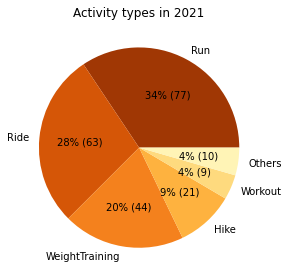

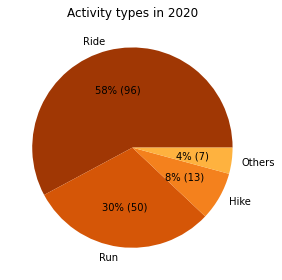

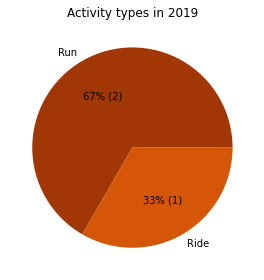

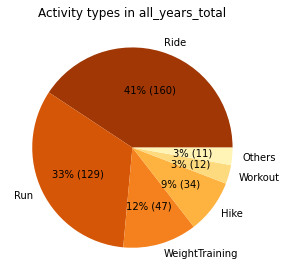

In [24]:
# Create pie chart labels
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.0f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Create years and dataframes for pie charts
years = df['start_date'].dt.year.unique()
dfs = []
for year in years:
    dfs.append(df[df['start_date'].dt.year == year])
dfs.append(df.copy())
years = np.append(years, 'all_years_total')

# Chart for each dataframe
for year, df_iter in zip(years, dfs):
    type_count = df_iter['type'].value_counts()
    small_cols = type_count < type_count.sum() * 0.03
    others = type_count[small_cols].sum()
    if others != 0:
        type_count = type_count[~small_cols]
        type_count['Others'] = others
    fig = plt.figure()
    ax = fig.gca()
    ax = plt.pie(type_count, labels = type_count.index, 
                 autopct=make_autopct(type_count), 
                 colors=COLOR)
    plt.title(f"Activity types in {year}")
    #plt.annotate(f"Total number of activities: {type_count.sum()}", (-0.8, -1.25), fontsize=16)
    plt.tight_layout()
    plt.savefig(path.join(FIGURES, f"sport_types_{year}"), dpi=800)



### Total info - maxes

In [25]:
max_dist = df['distance'].max()
longest_time = df['moving_time'].max()
heighest_point = df['elev_high'].max()
print(f'Heighest point[M]: {heighest_point}')
print(f'Longest activity[H]: {longest_time}')
print(f'Longest distance[KM]: {max_dist}')

print('Run statistics:')
print(df[df['type'] == 'Run']['distance'].describe())

summed = df['total_elevation_gain'].sum()
print(f'Total elevation gained[M]: {summed}')

Heighest point[M]: 2293.6
Longest activity[H]: 0 days 11:28:02
Longest distance[KM]: 100.536
Run statistics:
count    129.000000
mean       9.163219
std        4.212749
min        2.135400
25%        6.179300
50%        8.349600
75%       11.007400
max       25.453900
Name: distance, dtype: float64
Total elevation gained[M]: 135164.2


### Records by sport

In [26]:
stats_dict = {}
types = ['Run', 'Ride', 'Hike']
for sport in types:
    sport_df = df[df['type'] == sport]
    STATS = ['moving_time', 'elapsed_time', 'distance', 
            'total_elevation_gain', 'average_speed',
            'average_heartrate', 'kudos_count']
    sport_stats = {}
    for stat in STATS:
        sport_stats[f"{stat}_max"] = sport_df[f"{stat}"].max()
        sport_stats[f"{stat}_avg"] = sport_df[f"{stat}"].mean()
    if sport == 'Run':
        sport_stats["pace_min"] = sport_df["avg_pace"].min()
        sport_stats["pace_avg"] = sport_df["avg_pace"].mean()
    stats_dict[sport] = sport_stats

stats_dict

{'Run': {'moving_time_max': Timedelta('0 days 02:44:44'),
  'moving_time_avg': Timedelta('0 days 00:55:25.465116279'),
  'elapsed_time_max': Timedelta('0 days 02:54:39'),
  'elapsed_time_avg': Timedelta('0 days 00:57:37.356589147'),
  'distance_max': 25.4539,
  'distance_avg': 9.16321937984496,
  'total_elevation_gain_max': 853.1,
  'total_elevation_gain_avg': 147.30620155038758,
  'average_speed_max': 12.4308,
  'average_speed_avg': 10.189897674418605,
  'average_heartrate_max': 180.4,
  'average_heartrate_avg': 158.79140625000002,
  'kudos_count_max': 11,
  'kudos_count_avg': 4.744186046511628,
  'pace_min': 4.826720725938797,
  'pace_avg': 5.9471289506352125},
 'Ride': {'moving_time_max': Timedelta('0 days 06:07:44'),
  'moving_time_avg': Timedelta('0 days 01:48:40.437500'),
  'elapsed_time_max': Timedelta('0 days 07:12:32'),
  'elapsed_time_avg': Timedelta('0 days 02:05:05.693750'),
  'distance_max': 100.536,
  'distance_avg': 23.814288749999996,
  'total_elevation_gain_max': 2667.

### Correlation between average pace and average heart rate

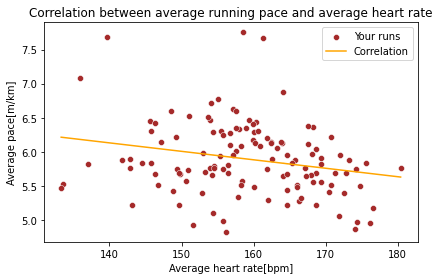

In [27]:
df_tmp = df[df['type'] == 'Run']

# DROP NA, INF, 0.0
df_tmp = df_tmp[~df_tmp['avg_pace'].isin([np.nan, np.inf, 0.0])]
df_tmp = df_tmp[~df_tmp['average_heartrate'].isin([np.nan, np.inf, 0.0])]
df_tmp = df_tmp[['avg_pace', 'average_heartrate']]
# remove outlier values
df_tmp = df_tmp[(np.abs(stats.zscore(df_tmp)) < 3).all(axis=1)]

# reshape and fit regression model
avg_hr = df_tmp['average_heartrate'].to_numpy().reshape(-1, 1)
avg_pace = df_tmp['avg_pace'].to_numpy().reshape(-1, 1)
lr = LinearRegression().fit(avg_hr, avg_pace)
predict = lr.predict(avg_hr)

# plot
sns.scatterplot(data=df_tmp, x='average_heartrate', y='avg_pace', color='brown')
sns.lineplot(x=avg_hr.reshape(1, -1)[0], y=predict.reshape(1, -1)[0], color='orange')
plt.legend(['Your runs', 'Correlation'])
plt.title('Correlation between average running pace and average heart rate')
plt.xlabel('Average heart rate[bpm]')
plt.ylabel('Average pace[m/km]')
plt.tight_layout()
plt.savefig(path.join(FIGURES,"hr_pace_correlation"), dpi=800)


### Elevation

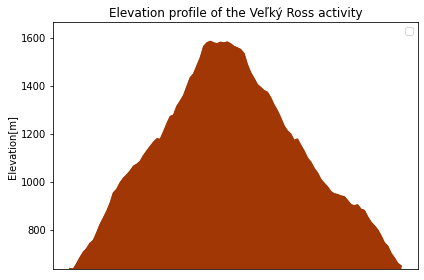

In [28]:
polylinez = "_znkHa{isBD@CBCAABGQ@EFE@IPACALRAcAD]BcABKHuAAE@CCAB]BOIoBKk@CYB}@Ni@h@eAN_@`AqEr@}BJc@FcAJcAJo@Bk@Ni@FiAHs@?SCEH[CU@SEK?}@Ge@?GHU@}@BOEKCm@EEAUG_@?IQi@AUB_@GWGO?WEGG_@Aa@BQA]@WDKCCLUHECUDi@AYBKA[DQ?g@BM?KGI?]E_@FU?]J_@?e@DWFm@AIDSCC@DC??@B@BCGG?MFy@?a@AGDE@ICOB[CQHYAKGW?y@BU?UCOBYGU@OEOKMC]FWB_@FWDI@UEO@MOW?]BQK]DMDq@DGDAAI@EEKAOFEBUA_@IM?SAMBIEYCI@EGQCa@FOLKHMCI?SBIDC?UJODSGc@BOJS@o@HKL@HCBi@BGAABIJEDUHILAFE?GNK@GT?JGN?FKFGLERKBIRSLo@JUJK@ITg@?K\\UNEHMB?DEFKDBBCASGKBKCOBIK[DcA\\q@VSFOBS@OPk@?IDGL_@HMLy@JOHCFGJ[@URQDOACDCCOEKBA?BCOHi@Va@POPEDLLAHU?IFQJCJa@P]HW?DCA@FECAGB@AC?C@??KRa@@MFG?KD?DIDWPYFSHELUFGHYTQXq@Py@@MDI@GTa@NEVUHABGNELYBUDKFGBu@F_@DMAQDM@OHODc@HMDWIO@BGGEOCYGMKu@CGOEE_@Jw@?IHU?KHMN]Bm@F]CMDE\\s@@QKc@AMDe@HS@SBG@YDGAKBIAk@Vs@AUFK@SIQBUFIHU?UHi@Ja@?[BM?UCI@q@AGJoA?e@No@LU?OF_@CMHI@u@BOCg@Hw@Gg@?c@DODu@?o@BW?u@ASHi@@o@AKGM@KEEEAEI?WH_@ASBMAEJe@?OFODgANe@LuA?[@AC?@QDKNKD@@CAE@LBBC?@A@@@?ABAA@F?C@C?B?Ag@TOCcAAQB_@Ji@FKC[?OGSFq@CYLIAEDKDIEG?MGQQC@MKG?SOEKGAGDAAMIQ]KEGK[MGGUCGFMGIAKGK?IE@??B@E?BAADBEAMJECG?GG]EK@SOKAOMG?GGKBBDEN?RKf@DXCLBR?VCNFP?TDH@VDNVPAVDJHJAH@HCPIDEC@?ATEB?HKD?LCFE@AHGB@NE@AHG?KJELED?DG@?FG?APCBC?GPKGAF@DC?CHSH@DC@?TC@EEKBABK?CDI@ILGCAJBJC?IKG@ATEAEHBD?IICCJDBAFKBEC?GCB@DCCCBCNIA@EABG?ACEFGCGDGCEJG?ABECARGCAHGHDJAFIBQXG@CS?DEME?GH?HCFODCDI?GDI@AHECGBGEKDCDEAADHTOPOACDDH@A?FC@FFIJCLIFGLEBAF@BCEIDK`@AHHJADACAZDJEF?BD@?BB?@CN?Pb@@`@CFCRC?AC?B@CC@?A@DCB@HF@?ABBCF@GA@@D?EC@@C?DCB@C@??BAC@??AB@?AA@?GGO?KAL?GC?DE?F@ABBCC@DCC?BB?CDACBE?DBCFD?b@@CDRAKGW?]DQCi@K_@KAABCEC@IG@MCM@G?LEIBUCQ@G@@?@CAKIAFC?IQGEC?KM@UHJAEA@CA?BAIH]A_@?KBEABAAK]IMKEBBADC?EG?ICHECCM?OGIE?GC?IGGKSMECCC@EACIKKAFCAGBUSUq@GEEMOMWKGIAKE@IIIAEG?MKACIBOACHKMECGIB?@CIE?GGABCEA@AIICAMYSAMIQOe@@DCAI_@CSAg@E@CHKDGAIKAACBG?Im@CGA@GEEQ@AE@MUC@ACG?OMGBAEC?CGEBQOG?GGMGIIKDIGGHECENKGOFIEGAEBECGDGGQ@GCEDWFMPKBI?IFQCQ@QOGFe@AYWGQAKG?EECBAAOAKI@CICCMGEE?WF@CI@YUI?GCIOK[AOIOOe@KOMAKEABC?QGGGEBGIOCEEG@IOI?OMO@ECQ?CCKAY[GDCGGFMEKSC?CBEGODMKEQE?GCIDGMI?MEGHG@GMC?AFKGM@ECGOGCIBIMI@EOMEMOE?GFIAESKKIDCA?EMAEDGE[IAEIAGECDUHGEAIA@CCOJMACFMF_@UEKOC?LGLC@SWCBEAGEIC?GC?IKMi@?@EA?GACMCMJMB[EO?GFBA@@Db@FVHRNLFNBV@f@Or@Cn@Eb@@ZLp@E|@J`@@R?T@`@Ad@T`BFLDl@F^PT@LNVFVRjBC~@Lx@Bh@Jb@JTCBBAC?OKMYSWMYCo@Oe@Cg@GQAYEGA]OQGFE?CJEBOCGKIRMBCLGBAFIJBHAPCBCRIHSd@Gp@Kf@?b@IX?`@Gn@@PBCAFIt@GJCb@KRBPI\\Ep@@b@CFE`@ELKFEP?NDNC^@b@GNE`@DLAJBBAAAHE??NGf@EJ@TGNCf@KN?LCBKA?XER?LEHBRCRId@@DA??LOTBHADFPC^H`@@h@Oh@EVIRKBECM@SVIG?DG@Ab@B@AFQNMb@FB?FAXGV@VKXAPEADDBL?VDRA^DHIh@APBDALBTEd@BXG\\KNALDFAPCNDDCTHBNZCj@DB?d@FP@RBHHHFLB\\HR@HTXBd@BFB@LXBP?VJPCV@JHNCXDNId@DREPB@NKHDBRBBCZBFBFJBHTG`@DHNFFLFBDHHDJv@JHHNN@FLANHJPHDPFH?HD@?FDJCNFJHFNXH@JLD?ADHBBHHFA@FECD@C@HNFNZ@XD@DRl@b@H\\VJDNXRV`@P?PK`@?FDFLXVNBZPFCBBB?FD@HJ?HDDVFFLD@JN\\FFHVHFJPR@HHJB@ADB?n@ADI@ABDZAb@D^Kp@@FD?@DEXEPC^KVDt@FRRJFDJ`@FHRLNXFl@?`@BVHPD`@BFDh@JNFDFPH^@b@J`@?LFFHXHt@`@r@@JALDHCDFD@PEFDCH?Jj@LN@NCXLp@CBG@CF?PDBFNFBCDFFBTLJDH?LFL?JCRM@MJ@EE??BAEA@?ABJDAE??DCEBCCCBABFAGALSVMHWn@MRMVc@f@IRQD@LIFSd@E^?XDPEDCLMXCNKR@@MHEJIECVMNGDELWBCPOHGJEADRZXCHIJ?Te@`BGv@H@@DHHPF^Dh@GRSNINABCb@KN?XHv@n@?DFFHZDXEh@GJa@?KCIQOGB^HL?FZ^XFFHZA?CHCBGF?JFFNFl@T\\ARLp@T^FHHBF\\NRLDFTbAd@BLDDLFLLHD?d@BJLF?FLJRHFNLF^b@d@XJNPp@R^ZVPX^VLVDd@JRL\\JPBTFN?JJVJp@PZNh@Tl@X\\P\\VVT`@p@RHHTHHLRx@XZZVNDVPd@^bAjALLVNLRL\\BR@`@TlBDh@Aj@"
with open('act1.json', 'r') as f:
   jsn = json.load(f)
coords = polyline.decode(polylinez)
sample_coords = coords[::int(round(len(coords)/100))]
if len(sample_coords) > 100:
   sample_coords = sample_coords[0:100]
data = requests.get(
   'https://api.opentopodata.org/v1/srtm30m',
   params={'locations': polyline.encode(sample_coords)}
).json()
elev = []
for item in data['results']:
   elev.append(item['elevation'])
df_new = pd.DataFrame()
df_new['elevation'] = pd.Series(elev)
df_new.plot.area(color=COLOR)
plt.legend('')
plt.xticks([])
plt.ylim(df_new['elevation'].min())
plt.ylabel('Elevation[m]')
plt.title(f"Elevation profile of the {jsn['name']} activity")
plt.tight_layout()

### Trail/Road run classificator

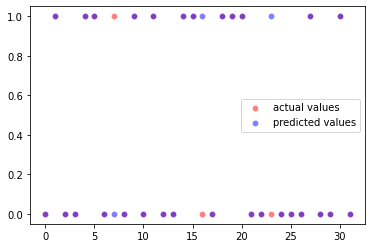

In [99]:
# classificator_df = df[df['type'] == 'Run']
# trail_runs = np.array([1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,
# 1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,
# 1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,
# 0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,
# 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
# 0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,
# 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
# 0,0,0])
# classificator_df['trail_run'] = trail_runs
# columns = ['total_elevation_gain', 'avg_pace', 'average_heartrate', 'elev_high', 'trail_run']
# classificator_df = classificator_df[columns]
# classificator_df = classificator_df.reset_index()
# classificator_df.to_csv('trail_classificator_dataset.csv')

classificator_df = pd.read_csv('trail_classificator_dataset.csv')
feature_names = ['total_elevation_gain', 'elev_high', 'avg_pace', 'average_heartrate']
features = classificator_df[feature_names]
response_var = classificator_df['trail_run']
nans = features[features.isnull().any(axis=1)]
features = features[~features.index.isin(nans.index)]
response_var = response_var[~response_var.index.isin(nans.index)]

X_train, X_test, y_train, y_test = train_test_split(features, response_var, random_state=0)
# scaler = MinMaxScaler() #nejaky scaling, dunno
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#logreg.score(X_test, y_test) = 0.9
predicts = logreg.predict(X_test)

# 1 = trail run, 0 = road run
sns.scatterplot(data=y_test.values, color='r', alpha=0.5)
sns.scatterplot(data=predicts, color='b', alpha=0.5)
plt.legend(['actual values', 'predicted values'])